In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
from touschek.touschek import get_LamTska, get_Touschek_Lifetime_Lebedev,\
                                get_Touschek_Lifetime_Valishev
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
i_to_photoel = 1/N_to_I
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

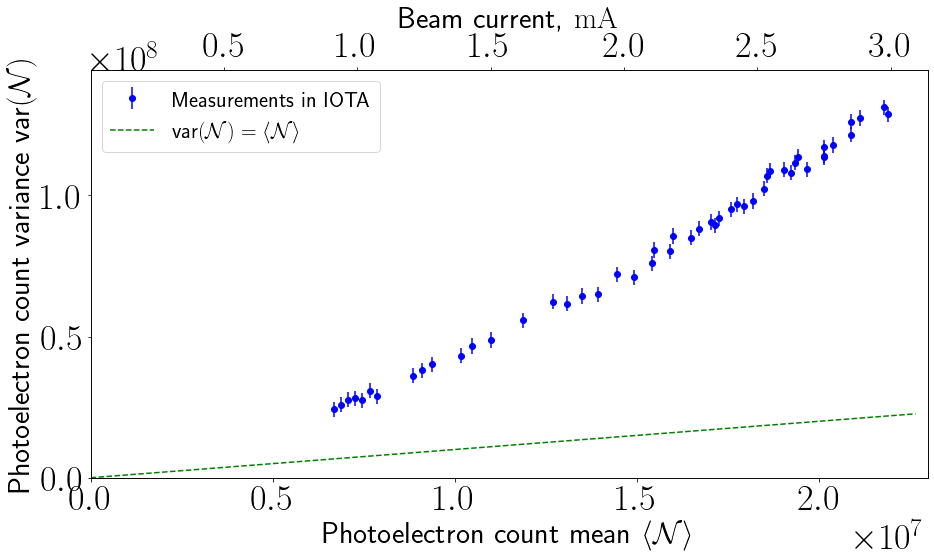

In [2]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [3]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)
df_EB = pd.read_csv("M_on_grid_precalc_EB.csv", index_col=0)
df_ET = pd.read_csv("M_on_grid_precalc_ET.csv", index_col=0)

In [4]:
df.head()

0.06  0.06857142857142857  0.07714285714285714  \
6.693879e+06  2.221984e+06         2.478707e+06         2.738453e+06   
6.868607e+06  2.232259e+06         2.489990e+06         2.750771e+06   
7.057312e+06  2.243369e+06         2.502187e+06         2.764074e+06   
7.249983e+06  2.254729e+06         2.514671e+06         2.777677e+06   
7.445827e+06  2.266292e+06         2.527336e+06         2.791512e+06   

              0.08571428571428573  0.09428571428571428  0.10285714285714287  \
6.693879e+06         3.001321e+06         3.267457e+06         3.536921e+06   
6.868607e+06         3.014674e+06         3.281838e+06         3.552339e+06   
7.057312e+06         3.029091e+06         3.297380e+06         3.569039e+06   
7.249983e+06         3.043832e+06         3.313292e+06         3.586113e+06   
7.445827e+06         3.058828e+06         3.329460e+06         3.603451e+06   

              0.11142857142857143          0.12  
6.693879e+06         3.809616e+06  4.085455e+06  
6.868607e+06         3.826136e+06  4.103022e+06  
7.057312e+06         3.843973e+06  4.122039e+06  
7.249983e+06         3.862211e+06  4.141467e+06  
7.445827e+06         3.880718e+06  4.161206e+06

In [5]:
es = df.columns.values.astype(np.float64)

In [6]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [7]:
def reconstruct_e(avN, varN, en='0'):
    Mexp = avN**2/(varN-avN)
    df0 = {'0':df, 'B':df_EB, 'T':df_ET}[en]
    return np.interp(Mexp,df0.loc[avN,:],es)

In [8]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [9]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [10]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['e_rec_EB'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='B'), axis=1)
meas_ROUND['e_rec_ET'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']], en='T'), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

# Systematic error of reconstructed e due to beam energy uncertainty

In [11]:
# 1e3*meas_ROUND.loc[:,['e_rec_EB', 'e_rec_ET']].apply(lambda col:col-meas_ROUND.loc[:,'e_rec'],axis=0)

In [12]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [13]:
# calculation of reconstructed sy
import lattice.lattice as lattice
#from lattice.summary_in_undulator import CalcTransverseBeamParams
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [14]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [15]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [16]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [17]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [18]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_r_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_r_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_r_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_r_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")


bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
sx_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_f_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_f_func = interp1d(bp_df["N"], bp_df['sz_cm_rms'],
                   bounds_error=False, fill_value="extrapolate")
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_f_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_f_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
Vrf_f_func = interp1d(bp_df["N"], bp_df['N:IRFEPA'],
                    bounds_error=False, fill_value="extrapolate")

In [19]:
def remove_outliers_omce(df, c1, l1):
    di = df[c1].diff().abs()
    return df[di < l1]
    
def remove_outliers(df, c1, l1, niter):
    for _ in range(niter):
        df = remove_outliers_omce(df, c1, l1)
    return df
round_df = remove_outliers(round_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)
round_df = remove_outliers(round_df,'ex_um', 0.01, 10)
round_df = remove_outliers(round_df,'ey_um', 0.01, 10)

flat_df = remove_outliers(flat_df,'N:IWCMI_recalibrated_to_IWCMI_absolute', 0.1, 10)


# Coupled lattice

In [20]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [21]:
with open(shift.get_6dsim_dir().fi("twiss4D_nuX0.29_nuY0.29.dat")) as f:
    f.read(1)
    ldf = pd.read_table(f, delim_whitespace=True)
ldf['nu1'] = 2*np.pi*ldf['Teta1/(2*PI)']
ldf['nu2'] = 2*np.pi*ldf['Teta2/(2*PI)']
ldf.head()

N     NAME  S[cm]   BetaX1    AlfaX1   BetaY1    AlfaY1  Teta1/(2*PI)  \
0  0    START   0.00  41.0619  0.017796  54.9686  0.024039      0.458775   
1  1  oLStart   0.00  41.0619  0.017796  54.9686  0.024039      0.458775   
2  2      oL1   1.75  41.0178  0.007376  54.8988  0.015874      0.459564   
3  2      oL1   3.50  41.0102 -0.003044  54.8575  0.007709      0.460353   
4  2      oL1   5.25  41.0391 -0.013464  54.8448 -0.000456      0.461139   

    BetaX2    AlfaX2   BetaY2    AlfaY2  Teta2/(2*PI)         U     DspX  \
0  39.2820 -0.017364  52.4795 -0.023431      0.043183  0.505862 -24.5745   
1  39.2820 -0.017364  52.4795 -0.023431      0.043183  0.505862 -24.5745   
2  39.3627 -0.028777  52.5758 -0.031592      0.042220  0.505862 -24.5745   
3  39.4834 -0.040191  52.7006 -0.039752      0.041261  0.505862 -24.5744   
4  39.6441 -0.051605  52.8540 -0.047913      0.040307  0.505862 -24.5744   

      DspXp      DspY         DspYp       Q1       Q2   M56[cm]       nu1  \
0  0.000023  0.000042  4.994970e-07  0.00000  0.00000  0.000000  2.882568   
1  0.000023  0.000042  4.994970e-07  0.00000  0.00000  0.000000  2.882568   
2  0.000023  0.000043  4.994970e-07  0.00335  0.00262  0.000046  2.887526   
3  0.000023  0.000044  4.994970e-07  0.00671  0.00523  0.000091  2.892483   
4  0.000023  0.000045  4.994970e-07  0.01006  0.00784  0.000137  2.897422   

        nu2  
0  0.271329  
1  0.271329  
2  0.265277  
3  0.259249  
4  0.253257

In [22]:
N = len(ldf.index)

In [23]:
c1 = np.cos(ldf['nu1'])
c2 = np.cos(ldf['nu2'])
s1 = np.sin(ldf['nu1'])
s2 = np.sin(ldf['nu2'])
e1 = np.exp(1j*ldf['nu1'])
e2 = np.exp(1j*ldf['nu2'])

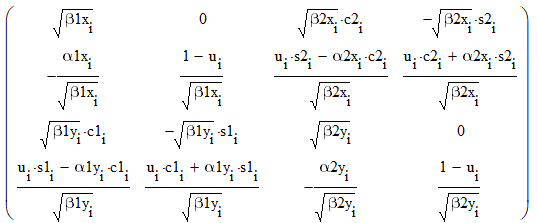

In [24]:
V = np.zeros(shape=(N, 4, 4))
V[:,0,0] = np.sqrt(ldf['BetaX1'])
V[:,0,2] = np.sqrt(ldf['BetaX2'])*c2
V[:,0,3] = -np.sqrt(ldf['BetaX2'])*s2
V[:,1,0] = -ldf['AlfaX1']/np.sqrt(ldf['BetaX1'])
V[:,1,1] = (1-ldf['U'])/np.sqrt(ldf['BetaX1'])
V[:,1,2] = (ldf['U']*s2-ldf['AlfaX2']*c2)/np.sqrt(ldf['BetaX2'])
V[:,1,3] = (ldf['U']*c2+ldf['AlfaX2']*s2)/np.sqrt(ldf['BetaX2'])
V[:,2,0] = np.sqrt(ldf['BetaY1'])*c1
V[:,2,1] = -np.sqrt(ldf['BetaY1'])*s1
V[:,2,2] = np.sqrt(ldf['BetaY2'])
V[:,3,0] = (ldf['U']*s1-ldf['AlfaY1']*c1)/np.sqrt(ldf['BetaY1'])
V[:,3,1] = (ldf['U']*c1+ldf['AlfaY1']*s1)/np.sqrt(ldf['BetaY1'])
V[:,3,2] = -ldf['AlfaY2']/np.sqrt(ldf['BetaY2'])
V[:,3,3] = (1-ldf['U'])/np.sqrt(ldf['BetaY2'])

In [25]:
U = np.array([
    [0,1,0,0],
    [-1,0,0,0],
    [0,0,0,1],
    [0,0,-1,0]
])

In [26]:
e1 = 8.99e-6
e2 = 9.56e-6
sp = 3.952e-4

In [27]:
Sigma = V@np.diag([e1,e1,e2,e2])@(np.transpose(V,axes=(0,2,1)))

In [28]:
Xi = U@V@np.diag([1/e1,1/e1,1/e2,1/e2])@np.transpose(V, axes=(0,2,1))@np.transpose(U)

In [29]:
Xi[0]

array([[ 1.34452838e+03,  1.63170329e+02, -7.23834221e+00,
        -4.33904084e+03],
       [ 1.63170329e+02,  8.67650416e+06, -4.74856961e+03,
        -5.32773351e+05],
       [-7.23834221e+00, -4.74856961e+03,  1.00678284e+03,
         2.23063690e+02],
       [-4.33904084e+03, -5.32773351e+05,  2.23063690e+02,
         1.16039035e+07]])

In [30]:
D = np.zeros(shape=(N,4))
D[:,0] = ldf['DspX']
D[:,1] = ldf['DspXp']
D[:,2] = ldf['DspY']
D[:,3] = ldf['DspYp']

In [31]:
D[0]

array([-2.45745e+01,  2.31820e-05,  4.21437e-05,  4.99497e-07])

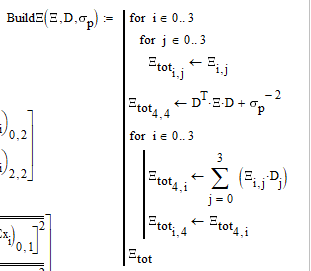

In [32]:
def BuildXi(Xi, D, sp):
    res = np.zeros(shape=(5,5))
    res[:4,:4] = Xi
    res[4,4] = D@Xi@D+1/sp**2
    res[4,:4] = Xi@D
    res[:4,4] = res[4,:4]
    return res

In [33]:
Xi.shape

(2164, 4, 4)

In [34]:
D.shape

(2164, 4)

In [35]:
Xitot = np.array([BuildXi(xi,d,sp) for xi,d in zip(Xi,D)])

In [36]:
Xitot[0]

array([[ 1.34452838e+03,  1.63170329e+02, -7.23834221e+00,
        -4.33904084e+03, -3.30411113e+04],
       [ 1.63170329e+02,  8.67650416e+06, -4.74856961e+03,
        -5.32773351e+05, -3.80915676e+03],
       [-7.23834221e+00, -4.74856961e+03,  1.00678284e+03,
         2.23063690e+02,  1.77811100e+02],
       [-4.33904084e+03, -5.32773351e+05,  2.23063690e+02,
         1.16039035e+07,  1.06623214e+05],
       [-3.30411113e+04, -3.80915676e+03,  1.77811100e+02,
         1.06623214e+05,  7.21471262e+06]])

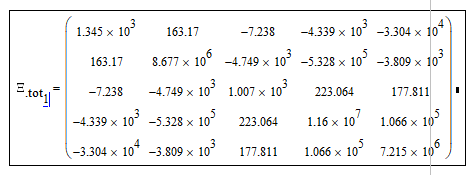

In [37]:
Sigmatot = np.array([np.linalg.inv(sl) for sl in Xitot])

In [38]:
Xitheta = np.array([
    np.array([
        [m[1,1],m[1,3],m[1,4]],
        [m[3,1],m[3,3],m[3,4]],
        [m[4,1],m[4,3],m[4,4]]
    ]) for m in Xitot
])

In [39]:
Xitheta[0]

array([[ 8.67650416e+06, -5.32773351e+05, -3.80915676e+03],
       [-5.32773351e+05,  1.16039035e+07,  1.06623214e+05],
       [-3.80915676e+03,  1.06623214e+05,  7.21471262e+06]])

In [40]:
Sigmax = np.array([
    np.array([
        [m[0,0],m[0,2]],
        [m[2,0],m[2,2]]
    ]) for m in Sigmatot
])

In [41]:
Sigmax[0]

array([[8.39002216e-04, 5.32043258e-06],
       [5.32043258e-06, 9.95871860e-04]])

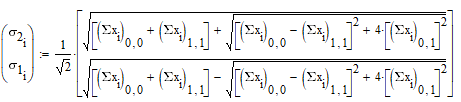

In [42]:
part1 = (Sigmax[:,0,0]+Sigmax[:,1,1])
part2 = np.sqrt((Sigmax[:,0,0]-Sigmax[:,1,1])**2+4*Sigma[:,0,1]**2)
s2 = 1/np.sqrt(2)*np.sqrt(part1+part2)
s1 = 1/np.sqrt(2)*np.sqrt(part1-part2)

In [43]:
gamma = get_from_config("gamma")

In [44]:
Gamma = np.diag([1,1,1/gamma])

In [45]:
SigmathetaBF = Gamma@np.linalg.inv(Xitheta)@Gamma

In [46]:
stheta2BF = np.linalg.eigvals(SigmathetaBF)

In [47]:
lattice.undulator_middle

1409.65

In [48]:
ldf['S[cm]'][767]

1409.34

In [49]:
und_idx = 767

In [50]:
Sigmax[und_idx]

array([[3.51373623e-03, 4.71334209e-05],
       [4.71334209e-05, 8.80056095e-04]])

In [51]:
SigmathetaBF[und_idx]

array([[ 4.93812938e-08, -2.50162881e-09,  9.89176044e-11],
       [-2.50162881e-09,  9.76641711e-08, -2.23413382e-11],
       [ 9.89176044e-11, -2.23413382e-11,  2.37921332e-12]])

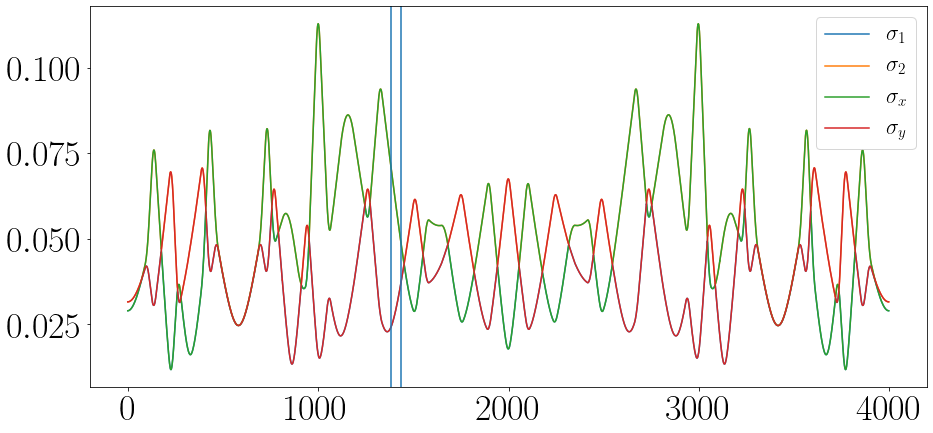

In [52]:
fix, ax = plt.subplots(figsize=(15,7))
ax.plot(ldf['S[cm]'],s1, label='$\sigma_1$')
ax.plot(ldf['S[cm]'],s2, label='$\sigma_2$')
ax.plot(ldf['S[cm]'],np.sqrt(Sigmax[:,0,0]), label='$\sigma_x$')
ax.plot(ldf['S[cm]'],np.sqrt(Sigmax[:,1,1]), label='$\sigma_y$')
x0,x1 = lattice.undulator_range
ax.axvline(x0)
ax.axvline(x1)
ax.legend()
plt.show()

In [53]:
# import plotly.graph_objects as go

# fig = go.Figure()

# # Add traces
# fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaX1'],
#                     mode='lines',
#                     name='BetaX1'))
# fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaX2'],
#                     mode='lines',
#                     name='BetaX2'))
# fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaY1'],
#                     mode='lines',
#                     name='BetaY1'))
# fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaY2'],
#                     mode='lines',
#                     name='BetaY2'))
# # fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=c1,
# #                     mode='lines+markers',
# #                     name='cos nu1'))
# # fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=c2,
# #                     mode='lines+markers',
# #                     name='cos nu2'))

# for x in lattice.camera_positions:
#     fig.add_vline(x)
# fig.add_trace(go.Scatter(x=100+np.array(lattice.camera_positions),
#                          y=300*np.ones(len(lattice.camera_positions)),
#                          text=lattice.camera_names, mode='text', showlegend=False))

# x0,x1 = lattice.undulator_range
# fig.add_vrect(x0=x0,x1=x1,fillcolor="LightSalmon", opacity=0.8,
#     layer="below", line_width=0)
# fig.add_trace(go.Scatter(x=[50+lattice.undulator_middle],
#                          y=[300],
#                          text=["Und."], mode='text', showlegend=False))

# fig.show()

In [54]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaX1']+ldf['BetaX2'],
                    mode='lines',
                    name='BetaX1+BetaX2'))

fig.add_trace(go.Scatter(x=lattice_df['S_cm'], y=lattice_df['Beta_cm_X'],
                    mode='lines',
                    name='BetaX'))

fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=ldf['BetaY1']+ldf['BetaY2'],
                    mode='lines',
                    name='BetaY1+BetaY2'))

fig.add_trace(go.Scatter(x=lattice_df['S_cm'], y=lattice_df['Beta_cm_Y'],
                    mode='lines',
                    name='BetaY'))

for x in lattice.camera_positions:
    fig.add_vline(x)
fig.add_trace(go.Scatter(x=100+np.array(lattice.camera_positions),
                         y=300*np.ones(len(lattice.camera_positions)),
                         text=lattice.camera_names, mode='text', showlegend=False))

x0,x1 = lattice.undulator_range
fig.add_vrect(x0=x0,x1=x1,fillcolor="LightSalmon", opacity=0.8,
    layer="below", line_width=0)
fig.add_trace(go.Scatter(x=[50+lattice.undulator_middle],
                         y=[300],
                         text=["Und."], mode='text', showlegend=False))


fig.show()

In [55]:
cl = lattice.CoupledLattice(shift.get_6dsim_dir().fi("twiss4D_nuX0.29_nuY0.29.dat"), gamma)

In [56]:
e1,e2,sp

(8.99e-06, 9.56e-06, 0.0003952)

In [57]:
res = cl.get_density_matrices(ldf,e1,e2,sp)

In [58]:
cl.get_cameras_sx_sy(e1,e2,sp)

(array([0.0185358 , 0.05582457, 0.08561144, 0.04706595, 0.0859471 ,
        0.05544863, 0.01974546]),
 array([0.04231485, 0.01695832, 0.02494706, 0.04902002, 0.0256296 ,
        0.01608898, 0.05551616]))

# Finding e1 e2 from measured sx sy

In [59]:
from scipy.optimize import minimize

In [60]:
df = round_df.loc[::100,:].reset_index(drop=True)
idx = 0
row = df.iloc[0,:]
Ibeam = row['N:IWCMI_recalibrated_to_IWCMI_absolute']
Nph = Ibeam*i_to_photoel
sxs = 1e-4*row[lattice.acnet_devices_X].values[[0,1,2,4,5,6,7]]
sys = 1e-4*row[lattice.acnet_devices_Y].values[[0,1,2,4,5,6,7]]
sp = dpp_r_func(Nph)

In [61]:
def f(e):
    e = e[0]
    sxs0, sys0 = cl.get_cameras_sx_sy(e,e,sp)
    return np.sum((sxs0-sxs)**2+(sys0-sys)**2)

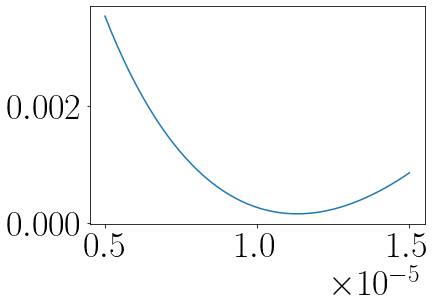

In [62]:
es = np.linspace(5e-6, 15e-6)
plt.plot(es, [f([e]) for e in es])

In [63]:
import scipy.optimize
scipy.optimize.fmin(f, x0=9e-6, xtol=0.05e-6)

Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 8
         Function evaluations: 16


array([1.130625e-05])

In [64]:
def fx(e):
    e = e[0]
    sxs0, sys0 = cl.get_cameras_sx_sy(e,e,sp)
    return np.sum((sxs0-sxs)**2)

In [65]:
scipy.optimize.fmin(fx, x0=9e-6, xtol=0.05e-6)

Optimization terminated successfully.
         Current function value: 0.000079
         Iterations: 9
         Function evaluations: 18


array([1.209375e-05])

In [66]:
def fy(e):
    e = e[0]
    sxs0, sys0 = cl.get_cameras_sx_sy(e,e,sp)
    return np.sum((sys0-sys)**2)

In [67]:
scipy.optimize.fmin(fy, x0=9e-6, xtol=0.05e-6)

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 6
         Function evaluations: 12


array([1.00125e-05])

In [68]:
row['ex_um']

0.10819085372604076

In [69]:
row['ey_um']

0.10174033121592133

In [70]:
e0 = 1e-4*(row['ex_um']+row['ey_um'])/2

In [71]:
Sigmax, Sigmatot = cl.get_density_matrices(ldf, e0, e0, sp)

In [72]:
ldf0 = lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
ldf0['sx'] = 1e-4*lattice.get_sigma_um(ldf0['Beta_cm_X'], 1e4*e0,
                                            ldf0['Dispersion_cm_X'], sp)
ldf0['sy'] = 1e-4*lattice.get_sigma_um(ldf0['Beta_cm_Y'], 1e4*e0, 0, 0)

In [73]:
Sigmax[0]

array([[ 8.52702855e-04, -2.28994572e-05],
       [-2.28994572e-05,  1.12783555e-03]])

In [74]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmax[:,0,0],
                    mode='lines',
                    name='Sigmax[0,0]'))

fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmax[:,1,1],
                    mode='lines',
                    name='Sigmax[1,1]'))

fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmax[:,0,1],
                    mode='lines',
                    name='Sigmax[0,1]'))


fig.add_trace(go.Scatter(x=ldf0['S_cm'], y=ldf0['sx']**2,
                    line=dict(dash='dash'),
                    name='sx^2 as uncoupled'))

fig.add_trace(go.Scatter(x=ldf0['S_cm'], y=ldf0['sy']**2,
                    line=dict(dash='dash'),
                    name='sy^2 as uncoupled'))

for x in lattice.camera_positions:
    fig.add_vline(x)
fig.add_trace(go.Scatter(x=100+np.array(lattice.camera_positions),
                         y=0.8e-2*np.ones(len(lattice.camera_positions)),
                         text=lattice.camera_names, mode='text', showlegend=False))

x0,x1 = lattice.undulator_range
fig.add_vrect(x0=x0,x1=x1,fillcolor="LightSalmon", opacity=0.8,
    layer="below", line_width=0)
fig.add_trace(go.Scatter(x=[50+lattice.undulator_middle],
                         y=[0.8e-2],
                         text=["Und."], mode='text', showlegend=False))


fig.show()

In [75]:
Sigmatot[0]

array([[ 8.52702855e-04, -4.54017572e-09, -2.28994572e-05,
         3.88583699e-07,  3.81227183e-07],
       [-4.54017572e-09,  1.30956919e-07,  5.19657062e-07,
         2.65381952e-09, -3.59625163e-13],
       [-2.28994572e-05,  5.19657062e-07,  1.12783555e-03,
        -6.38471090e-09, -6.53780303e-13],
       [ 3.88583699e-07,  2.65381952e-09, -6.38471090e-09,
         9.79225233e-08, -7.74875723e-15],
       [ 3.81227183e-07, -3.59625163e-13, -6.53780303e-13,
        -7.74875722e-15,  1.55131206e-08]])

In [76]:
gamma_x_um_m1 = (1+ldf0["Alpha_X"]**2)/ldf0["Beta_cm_X"]/1e4
gamma_y_um_m1 = (1+ldf0["Alpha_Y"]**2)/ldf0["Beta_cm_Y"]/1e4
angle_spread_x = np.sqrt(ldf0["dDx/dS"]**2*sp**2 + e0*1e4*gamma_x_um_m1)
angle_spread_y = np.sqrt(e0*1e4*gamma_y_um_m1)

In [77]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmatot[:,1,1],
                    mode='lines',
                    name='Sigmatot[1,1]'))

fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmatot[:,3,3],
                    mode='lines',
                    name='Sigmatot[3,3]'))

fig.add_trace(go.Scatter(x=ldf['S[cm]'], y=Sigmatot[:,1,3],
                    mode='lines',
                    name='Sigmatot[1,3]'))


fig.add_trace(go.Scatter(x=ldf0['S_cm'], y=angle_spread_x**2,
                    line=dict(dash='dash'),
                    name="(sx')^2 as uncoupled"))

fig.add_trace(go.Scatter(x=ldf0['S_cm'], y=angle_spread_y**2,
                    line=dict(dash='dash'),
                    name="(sy')^2 as uncoupled"))

for x in lattice.camera_positions:
    fig.add_vline(x)
fig.add_trace(go.Scatter(x=100+np.array(lattice.camera_positions),
                         y=2e-6*np.ones(len(lattice.camera_positions)),
                         text=lattice.camera_names, mode='text', showlegend=False))

x0,x1 = lattice.undulator_range
fig.add_vrect(x0=x0,x1=x1,fillcolor="LightSalmon", opacity=0.8,
    layer="below", line_width=0)
fig.add_trace(go.Scatter(x=[50+lattice.undulator_middle],
                         y=[2e-6],
                         text=["Und."], mode='text', showlegend=False))


fig.show()